## Importing Required Dependencies

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Activation, Dropout, concatenate, Input

<center><img src="https://miro.medium.com/max/700/0*BCO1K3ra3-alFu62.png"/></center>


## UNet Model 

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batch_norm = True):

  # first layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), 
             kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
  if batch_norm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)

  # second layer
  x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),
             kernel_initializer = 'he_normal', padding = 'same')(x)
  if batch_norm:
    x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def unet(input_img, n_filter = 16, dropout = 0.1, batch_norm = True):

  c1 = conv2d_block(input_img, n_filter * 1, kernel_size = 3, batch_norm =  batch_norm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv2d_block(p1, n_filter * 2, kernel_size = 3, batch_norm = batch_norm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv2d_block(p2, n_filter * 4, kernel_size = 3, batch_norm = batch_norm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv2d_block(p3, n_filter * 8, kernel_size = 3, batch_norm = batch_norm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv2d_block(p4, n_filter * 16, kernel_size = 3, batch_norm = batch_norm)

  # Expansive path
  u6 = Conv2DTranspose(n_filter * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6,c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filter * 8, kernel_size = 3, batch_norm = batch_norm)

  u7 = Conv2DTranspose(n_filter * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filter * 4, kernel_size = 3, batch_norm = batch_norm)

  u8 = Conv2DTranspose(n_filter * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filter * 2, kernel_size = 3, batch_norm = batch_norm)

  u9 = Conv2DTranspose(n_filter * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filter * 1, kernel_size = 3, batch_norm = batch_norm)

  output = Conv2D(2, (1, 1), activation = 'softmax')(c9)
  model = Model(inputs = [input_img], outputs = output)

  return model

In [7]:
input_img = Input((256, 256, 3), name = 'img')

unet_model = unet(input_img, n_filter = 16, dropout = 0.1, batch_norm = True)

## Summary of UNet Model

In [9]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 16  64         ['conv2d_19[0][0]']              
 ormalization)                  )                                                           

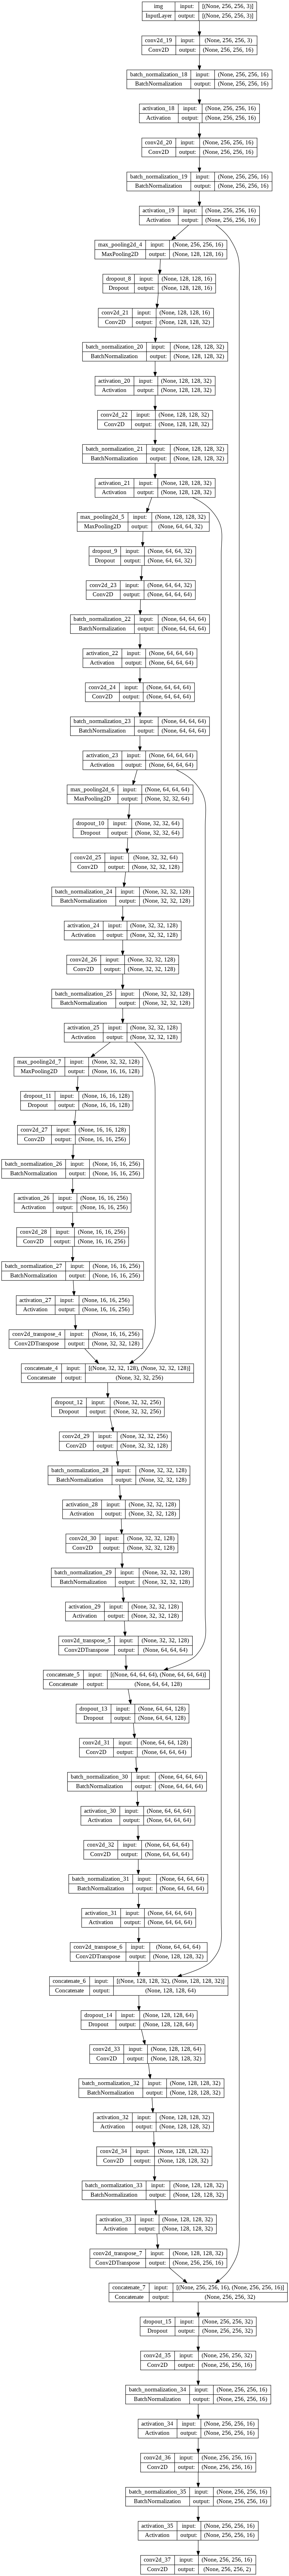

In [10]:
tf.keras.utils.plot_model(unet_model, show_shapes = True, show_layer_names = True, to_file = 'unet_model.png')